### User - Stanley Nguyen

In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

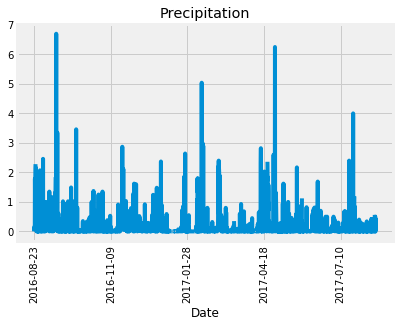

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precipitation = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date.between('2016-08-23','2017-08-23')).\
    order_by(Measurement.date).all()

# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation[:],columns=['Date','Precipitation'])



# Sort the dataframe by date
df.set_index('Date',inplace=False)
df.head()
# Use Pandas Plotting with Matplotlib to plot the data
dates=df["Date"]
dates.tolist()
plt.plot(df["Precipitation"])

# Rotate the xticks for the dates
plt.title('Precipitation')
plt.xlabel('Date')

labels=[dates[0],dates[500],dates[1000],dates[1500],dates[2000]]
loc=[0,500,1000,1500,2000]

plt.xticks(loc,labels,rotation="vertical")

# fig.autofmt_xdate()
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?

stationnumbers=session.query(Station.station).count()
stationnumbers

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

activedf = session.query(Measurement.station,Measurement.tobs)
statdf=pd.DataFrame(activedf[:],columns=["Stations","TOBS"])
activestations=statdf.groupby("Stations").count().sort_values('TOBS',ascending=False)
activestations

,TOBS
Stations,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

mostactstat=statdf.loc[statdf['Stations']==activestations.index[0]]
mostactstat
result =[mostactstat["TOBS"].min(),mostactstat["TOBS"].max(),mostactstat["TOBS"].mean()]
result 

[54.0, 85.0, 71.66378066378067]

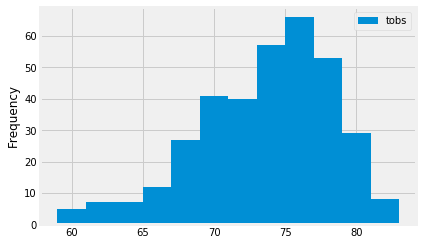

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


totaltemp=activestations.index[0]
totaltemp
total = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.date.between('2016-08-23','2017-08-23')).\
    filter(Measurement.station==totaltemp).\
    order_by(Measurement.date).all()

tempdf = pd.DataFrame(total)


tempdf.plot.hist(bins=12)
plt.ylabel('Frequency')
plt.show()

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-05-21', '2013-05-21'))

[(53.0, 72.26735316552251, 86.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

mytemptrip=calc_temps('2016-08-23','2017-08-23')
mytemptrip

[(58.0, 74.59058295964125, 87.0)]

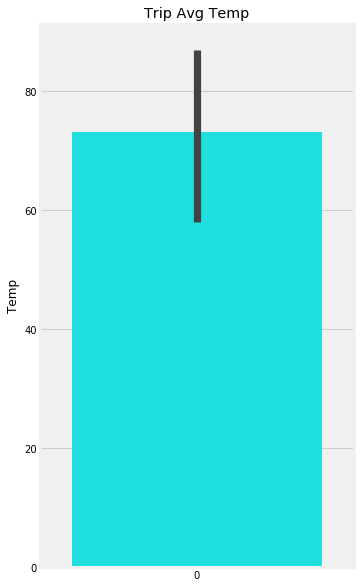

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(5,10))
sns.barplot(data=mytemptrip,color="aqua")
plt.ylabel('Temp')
plt.title('Trip Avg Temp')


# .plot()
plt.show()

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainavg = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Measurement.prcp).\
    filter(Measurement.date.between('2016-08-23','2017-08-23')).\
    group_by(Measurement.station).\
    join(Station, Measurement.station==Station.station).\
    order_by(Measurement.prcp.desc()).all()

rainavgdf = pd.DataFrame(rainavg)
rainavgdf

,station,name,latitude,longitude,prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,0.45
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,0.08
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,0.06
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,0.00
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,0.00
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,0.00
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,NaN
